# Magnet Simulation Jupyteylab (Asymmetric)

## Import packages

In [2]:
import numpy as np
import magpylib as magpy
import matplotlib.pyplot as plt

## Define parameters for the magnets. 

In [3]:
n_magnets = 18 # Number of magnet per ring
n_rings = 16 # Number of rings
cube_length = 10 # Length of cube in mm
magnet_strength = 5492 #  Magnet strength in gauss

ring_diameter = 88 # Ring diameter in mm
ring_length = 180 # Ring length in mm
plot_length= 40 # Length of field map plotted in mm
dsv = 50 # Diameter of the spherical volume in mm
eclipse_ratio = 1 # Minor axis/major axis ratio

## generate_magnet()
Takes in the magnet arrangement "halbach", which contains the position and property of the magnets. 

Note, the "z_pos" is the length of the rings. The "x_pos" is the radius from (0,0), and "y_pos" is set to 0. 

In the first three of the "for ang in angles" for loop, the eclipsal position is calculated for each magnet with the eclipse formula in polar coordinates. "a" is radius of the major axis and "b" is the radius of the semi axis.

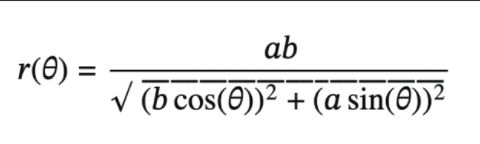

Note, the line magnetization=() defines the magnet strength. In Magpylib 5.0, magnetization is in the unit of Ampere per meter. To convert from gauss to ampere per meter. Firstly, gauss is converted to tesla, then the following fomula is use, which obtained a value of 437039A/m. "H" is the magnetization in A/M. "u" is the permeaibily of air. "B" is the magnetic field in Tesla. 

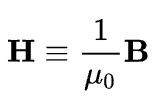


In the end the class "halbach" is returned. 

In [4]:
def generate_magnet(halbach):
    # Protect code if n_rings = 1
    if n_rings != 1:
        ring_spacing = ring_length / (n_rings - 1)
    else:
        ring_spacing = 1

    # Define starting z position from the bottom, so center is at (0,0,0)
    z_starting_pos = -ring_length / 2

    # Loop to generate ring by ring
    for r in range(n_rings):
        # Setting diameter for each ring for optimization
        ring_diameter_array = [
            ring_diameter ,
            ring_diameter ,
            ring_diameter ,
            ring_diameter ,
            ring_diameter + 5.3,
            ring_diameter + 5.4,
            ring_diameter + 4.9,
            ring_diameter + 5.3,
            ring_diameter + 5.3,
            ring_diameter + 4.9,
            ring_diameter + 5.4,
            ring_diameter + 5.3,
            ring_diameter ,
            ring_diameter ,
            ring_diameter ,
            ring_diameter ,
        ]

        # Setting XYZ position per ring
        z_pos = z_starting_pos + r * ring_spacing
        y_pos = 0

        # Define the angles between each magnet in a circle
        angles = np.linspace(0, 360, n_magnets, endpoint=False)

        for ang in angles:
            # Calculate Eclipse
            a = ring_diameter_array[r] / 2
            b = a * eclipse_ratio
            x_pos = (a * b) / (np.sqrt((b * np.cos(np.radians(ang))) ** 2 + (a * np.sin(np.radians(ang))) ** 2))

            # Defining the position and rotation of magnet
            cube = magpy.magnet.Cuboid(
                dimension=(cube_length, cube_length, cube_length),
                magnetization=(magnet_strength / 1.25663753 * 100, 0, 0),  # converted using B = T/u
                position=(x_pos, y_pos, z_pos)
            )
            cube.rotate_from_angax(ang, 'z', anchor=0)
            cube.rotate_from_angax(ang, 'z')
            halbach.add(cube)
    return halbach


The class is defined as "halbach". It stores the position, rotation, and properties of the magnet arragements.

In [5]:
halbach = magpy.Collection()
halbach = generate_magnet(halbach)

## plot_halback()
This function simply plot the magnet collection "halbach". 

In [6]:
def plot_halback(halbach):
    # Defining graph
    fig = halbach.show(backend='plotly', return_fig=True)
    # Update axis labels
    fig.update_layout(
        scene=dict(
            xaxis_title="X-axis (mm)",
            yaxis_title="Y-axis (mm)",
            zaxis_title="Z-axis (mm)"
        )
    )
    # Show the figure
    fig.show()

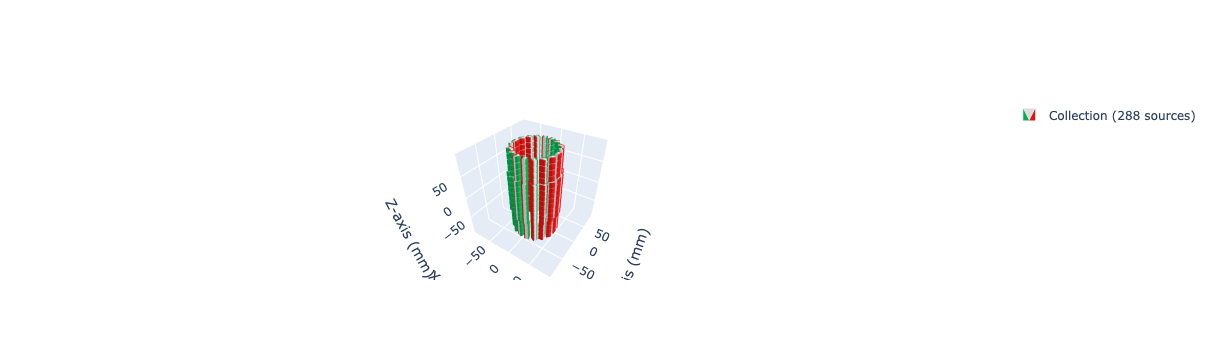

In [8]:
plot_halback(halbach)

## calculate_ppm()

This function takes in the argument "halbach" and "dsv", and returns the uniformity in parts per million, average B field, and the max deviation from the average field within the choosen DSV. 

It will be called in the plot_result() function.

In [9]:
def calculate_ppm(halbach, dsv):
    # Define the grid points over the DSV
    r = dsv / 2
    grid = np.mgrid[-r:r:20j, -r:r:20j, -r:r:20j].T.reshape(-1, 3)

    # Spherical shape is defined
    distances = np.linalg.norm(grid, axis=1)
    grid = grid[distances <= r]

    # Get magnetic field values at each grid point
    B = halbach.getB(grid)
    B_magnitude = np.linalg.norm(B, axis=1)

    # Calculate the mean and maximum deviation
    B_avg = np.mean(B_magnitude)
    B_max_deviation = np.max(np.abs(B_magnitude - B_avg))

    # Calculate uniformity in ppm
    uniformity_ppm = (B_max_deviation / B_avg) * 1e6
    return uniformity_ppm, B_avg, B_max_deviation

## plot_result()

This function takes in "halbach", and show graph of the uniformity of the chosen "plot_length" defined under 1.2. 

In [10]:
def plot_result(halbach, print_result=False, arrow=False,plot_show =True):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    # Set the z position view of the three graphs
    z_positions = [-plot_length/2, 0, plot_length/2]

    for z_pos, ax in zip(z_positions, axes):
        # Grid is defined
        grid = np.mgrid[-plot_length/2:plot_length/2:100j, -plot_length/2:plot_length/2:100j, z_pos:z_pos:1j].T[0]
        
        # Separate grid in to X and Y axis
        X, Y, _ = np.moveaxis(grid, 2, 0)
        B = halbach.getB(grid)
        
        # Magnitude of field vector is taken and converted to mT
        Bamp = np.linalg.norm(B, axis=2)*1000

        # Define field map
        pc = ax.contourf(X, Y, Bamp, levels=35, cmap="jet")
        
        # Show field vector
        if arrow == True:
            Bx, By, _ = np.moveaxis(B, 2, 0)
            ax.streamplot(X, Y, Bx, By, color="k", density=1.5, linewidth=1)

        # Add colorbar
        fig.colorbar(pc, ax=ax, label="|B| mT")

        # Figure styling
        ax.set(
            title=f"Field at z = {z_pos} mm",
            xlabel="x-position",
            ylabel="y-position",
            aspect=1,
        )

    # Calculate and display uniformity in ppm, field strength, and max deviation on graph
    uniformity_ppm, B_average, B_max_deviation = calculate_ppm(halbach, dsv)
    plt.suptitle(f"Average field: {B_average*1000:.2f}mT   Max deviation: {B_max_deviation*1000:.2f}mT   Homogeneity: {uniformity_ppm:.0f} ppm over {dsv} mm DSV", fontsize=16)
    plt.tight_layout()

    # Print for excel spread sheet comparison. Have no effect on outcome.
    if print_result:
        result = [f'{B_average*1000:.2f}', f'{uniformity_ppm:.0f}',f'{B_max_deviation*1000:.2f}', dsv, ring_diameter, ring_length, n_rings*n_magnets, n_magnets, n_rings, eclipse_ratio]
        formatted_data = '\t'.join(map(str, result))
        print (formatted_data)
    
    if plot_show == True:
        plt.show()

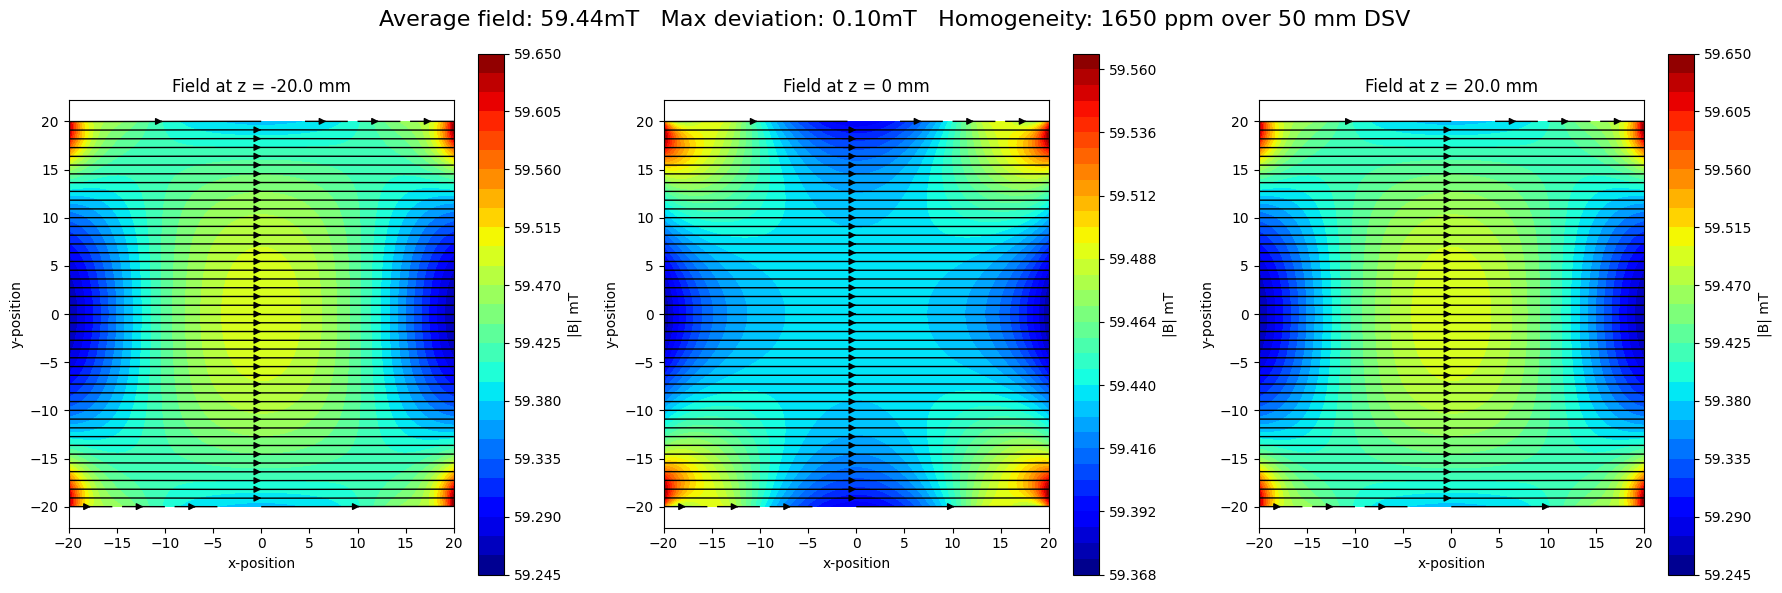

In [11]:
plot_result(halbach, print_result=False, arrow=True, plot_show=True)